# STA and Merge: Ganglion Cells in the Retina
- **Author**: Javier Cruz
- **Contact**: https://github.com/sisyphvs
- **Last Modification**: January 30, 2024
- **Description**: This document contains the first steps for data processing.

## Introduction

### Importing Libraries

In [1]:
%pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from pylab import rand
from pyret import filtertools
import h5py
import pickle

In [3]:
sys.path.append("../")

In [4]:
from scripts import load_yaml_config

### Paths and configuration

In [5]:
plt.style.use("seaborn-v0_8-darkgrid")

In [6]:
configPath = "../config/"
config = load_yaml_config(configPath + "general_config.yml")
SPIKE_TIMES_PATH = ".." + config["paths"]["data"]["result_merged"]
TIMESTAMPS_PATH = ".." + config["paths"]["data"]["start_end_frames"]
STIM_PATH = ".." + config["paths"]["data"]["stim_data"]

### Loading the data

#### Spike times

In [7]:
units = h5py.File(SPIKE_TIMES_PATH, 'r')
spt_units = units["spiketimes"]
SPT = {}
for elem in spt_units.keys():
    SPT[elem] = np.array(spt_units[elem])
units.close()

#### Time stamps

In [8]:
TIMESTAMPS_FILE = open(TIMESTAMPS_PATH, 'r')
TIMESTAMPS = []
count = 0
for columns in (raw.strip().split() for raw in TIMESTAMPS_FILE):
    if count == 1:
        pre = float(columns[0])
    if count != 0:
        if pre != float(columns[0]):
            print(pre, columns[0])
        TIMESTAMPS.append((float(columns[0])))
        pre = float(columns[1])
    count=+1
TIMESTAMPS_FILE.close()
TIMESTAMPS = [x for x in TIMESTAMPS if(x >= 28850904 and x <= 52950782)]

#### Total spikes

In [9]:
TOTAL_SPIKES = {}
for stk in SPT.keys():
    st = SPT[stk]
    TOTAL_SPIKES[stk] = len(st[(st > TIMESTAMPS[0]) * (st < TIMESTAMPS[-1])])

#### Stim data

In [10]:
STIM_FILE = h5py.File(STIM_PATH, 'r')
STIM_DATA = []
test = STIM_FILE["stim"]
for i in range(72001):
    st = test[i][0]
    obj = STIM_FILE[st]
    STIM_DATA.append(obj[:][:])
STIM_FILE.close()
STIM_DATA = np.array(STIM_DATA)
for elem in STIM_DATA:
    for i in range(35):
        for j in range(35):
            if elem[i][j] == 1.:
                elem[i][j] = 255.
            elif elem[i][j] == -1.:
                elem[i][j] = 0.

### Constants

In [11]:
FPS = config["params"]["FPS"]
FRAME_TIME = 1/FPS
TIME = np.arange(-2,28,1)*FRAME_TIME
TIME_CONT = np.linspace(-2,28,300)*FRAME_TIME

## Computing the STA

In [12]:
TIME_DATA = np.array(TIMESTAMPS)
STA_FRAMES = 30
FRAMES_AFTER = 3
HISTORY = STA_FRAMES - FRAMES_AFTER

**_LOOP ENTRY POINT_**

In this part, we use `filtertools.sta(...)` method which belongs to pyret library. Here, we use the data loaded before: 

In [63]:
def get_sta(cell):
    sta, tax = filtertools.sta(TIME_DATA, STIM_DATA, SPT[cell], HISTORY, nsamples_after=FRAMES_AFTER)
    return (cell, sta)

In [64]:
STA = {}
for cell in SPT.keys():
    STA[cell] = get_sta(cell)[1]

Now, we can decompose the STA in spatial and temporal arrays with `filtertools.decompose(...)` method which also belongs to pyret library. 

In [65]:
#STA data set
DATA_STA = list(STA.keys())

S_DATA = {}
T_DATA = {"time": TIME,
          "time_cont": TIME_CONT,
          "contrast": {}}

for c in DATA_STA:
    try:
        #decompose
        s,t = filtertools.decompose(STA[c])

        #center data around horizontal axis
        t_0 = (t[-1] + t[-2] + t[-3] + t[-4] + t[-5])/5
        new_t = t - t_0

        #save data
        S_DATA[c] = s
        T_DATA["contrast"][c] = new_t
    except:
        del STA[c]

### Data filtering 

In [66]:
def get_amplitude(sta,thr):
    vmean = np.mean(sta)
    std = np.std(sta)
    amp = np.max(((np.max(sta)-vmean), abs(np.min(sta)-vmean)))
    if amp > std * thr:
        return np.abs(amp)
    else:
        return 0

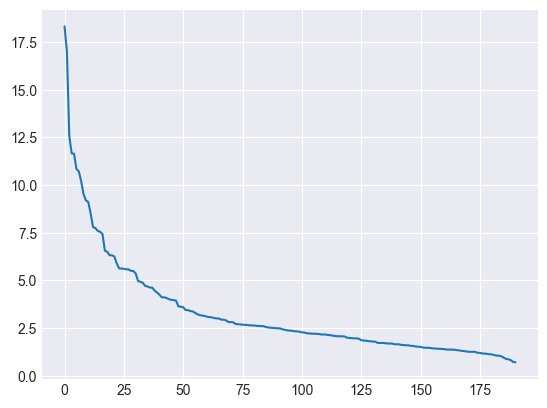

In [67]:
AMPLITUDES = np.zeros(len(STA))
for i, cell in enumerate(STA.keys()):
    AMPLITUDES[i] = get_amplitude(STA[cell], thr = 4)

plt.plot(np.sort(AMPLITUDES)[::-1])
plt.show()

Here, we filter the data by its amplitude. Note that at the begging we had approximately 600 cells, and after this first filter, we have approximately 200 cells.  

In [68]:
GOOD_STAS = []
for cell in STA.keys():
    if get_amplitude(STA[cell], thr = 4) > 0:
        GOOD_STAS.append(cell)

Here, we calculate RFs data with `filtertools.get_ellipse(...)` method. Note that there are cells that may produce problems in this part.

In [69]:
def get_rfs(keys):
    rfs = {}
    for i, cell in enumerate(keys):
        try:
            s = S_DATA[cell]
            center, width, theta = filtertools.get_ellipse(s)
            rfs[cell] = {}
            rfs[cell]['x'] = x = float(center[0])
            rfs[cell]['y'] = y = float(center[1])
            rfs[cell]['w'] = w = width[0]
            rfs[cell]['h'] = h = width[1]
            rfs[cell]['a'] = a = theta
            rfs[cell]['exc'] = np.sqrt(1 - ((np.min((h,w))/2)**2/(np.max((h,w))/2)**2))
        except:
            continue
    return rfs

RFS = get_rfs(GOOD_STAS)

In [70]:
len(STA), len(GOOD_STAS), len(RFS), len([c for c in RFS if RFS[c]['exc'] < .9])

(191, 191, 191, 191)

In this part, there is a second filter which is the eccentricity of the ellipse:

In [71]:
DATA_RFS = [c for c in RFS if RFS[c]['exc'] < .9]

### Ploting the STA

In [72]:
def plot_rfs(rfs, keys,  xmax=40, xmin=0, ymin=0, ymax=40, thrsh=0.9):
    ells = []
    b = 0
    for i, cell in enumerate(keys):
        x = rfs[cell]['x']
        y = rfs[cell]['y']
        w = rfs[cell]['w']
        h = rfs[cell]['h']
        a = rfs[cell]['a']
        exc = rfs[cell]['exc']
        if (exc < thrsh) * (y < xmax) * (x < ymax) * (y > xmin) * (x > ymin):
            ells.append(Ellipse(xy = (y,x), width = w, height = h, angle = a,
                                color = rand(3), fill = False, alpha = 0.6,
                                label = cell.strip('temp_'), linewidth = 2.))
        else:
            b += 1

    fig = plt.figure()
    fig.set_size_inches(8,8)
    ax = fig.add_subplot(111, aspect = 'equal')
    for i, e in enumerate(ells):
        ax.add_artist(e)
        #ax.annotate(e.get_label(), e.get_ellipse)
    fig.suptitle('disp cells = ' + str(len(ells)))
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

Here, we can observe the different positions and sizes of cells. Note that in the first iterations of the loop, it may be cells with very similar sizes and positions. This cells could represent the same cell duplicated, and in the following steps we will delete those cells.  

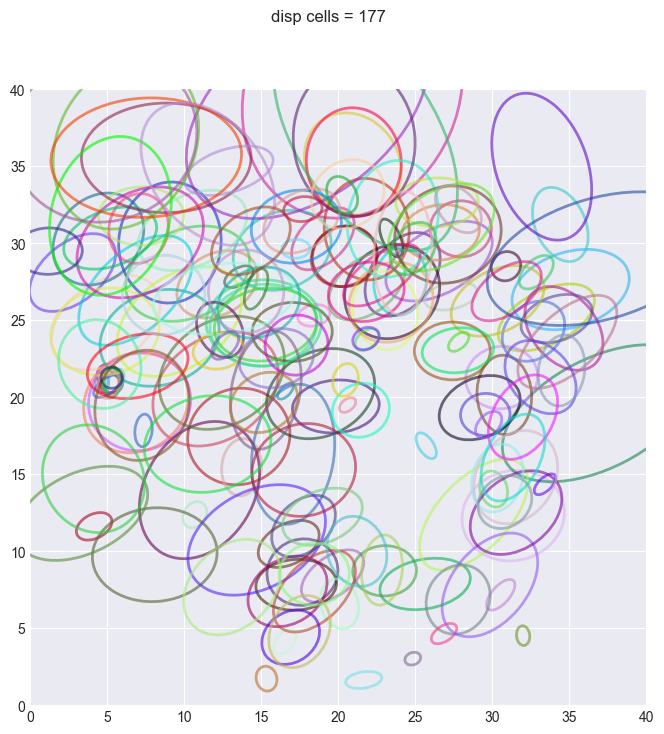

In [73]:
plot_rfs(RFS, RFS.keys())

### Merge Similar

In [74]:
def merge_similar(rfs, cells):
    from itertools import combinations as cb
    sims = 0
    pairs = []
    for a, b in cb(cells, 2):
        x = np.isclose(rfs[a]['x'], rfs[b]['x'], atol = 1)
        y = np.isclose(rfs[a]['y'], rfs[b]['y'], atol = 1)
        w = np.isclose(rfs[a]['w'], rfs[b]['w'], rtol = .3)
        h = np.isclose(rfs[a]['h'], rfs[b]['h'], rtol = .3)
        z = np.isclose(rfs[a]['a'], rfs[b]['a'], rtol = .2)
        #plt.scatter(rfs[a]['x'], rfs[b]['x'])
        if x * y * w * h * z:
            sims += 1
            #print('{} is similar to {}'.format(a, b))
            pairs.append([a,b])
    print('found {} similarities from a maximum of {}'.format(sims, len(cells)**2))
    return pairs

In [75]:
sims = merge_similar(RFS,DATA_RFS)

found 0 similarities from a maximum of 36481


In [76]:
def compare_STA(stas, a, b):
    fig,axs = plt.subplots(2,2)
    fig.set_size_inches(6,6)
    colors = ['k', 'C3', 'C2']
    ells = []
    for i, cell in enumerate([a,b]):
        x = RFS[cell]['x']
        y = RFS[cell]['y']
        w = RFS[cell]['w']
        h = RFS[cell]['h']
        z = RFS[cell]['a']
        #exc = RFS[cell]['exc']
        ells.append(Ellipse(xy = (y, x), width = w, height = h, angle = z,
                            color = colors[i], fill = False, alpha = 0.85, linewidth = 4.))

    for e in ells: 
        axs[1][1].add_artist(e)
    #ax2.set_title()
    sa, ta = filtertools.decompose(stas[a])
    sb, tb = filtertools.decompose(stas[b])
    #vmax = (np.max(abs(sa - sb)))
    axs[1][1].imshow(sa - sb, cmap = 'viridis', interpolation = 'None')
    axs[1][1].set_title('Merge')
    axs[0][1].imshow(sa, cmap = 'viridis', interpolation = 'None')
    axs[1][0].imshow(sb, cmap = 'viridis', interpolation = 'None')
    axs[0][1].set_title('Cell ' + a)
    axs[1][0].set_title('Cell ' + b)
    axs[0][0].plot(ta, label = a, color = colors[0])
    axs[0][0].plot(tb, label = b, color = colors[1])
    axs[0][0].legend()
    axs[0][0].set_xlim([0,None])
    return fig

### Plots

In [77]:
for p in sims:
    fig = compare_STA(STA, p[0], p[1])
    fig.tight_layout()
    fig.show()

### Removing

In [78]:
TO_REMOVE = []

'''
TO_REMOVE = [
    [189,190],
    [267,495],
    [392,527]
]
'''

for elem in TO_REMOVE:
    if ["temp_" + str(elem[0]),"temp_" + str(elem[1])] in sims:
        sims.remove(["temp_" + str(elem[0]),"temp_" + str(elem[1])])

In [79]:
for sim in sims:
    try:
        print(SPT[sim[1]][0])
    except:
        continue
        
    SPT[sim[0]] = np.sort(np.concatenate((SPT[sim[0]], SPT[sim[1]])))

In [80]:
for s in sims:
    try:
        del DATA_RFS[s[1]]
    except:
        continue

In [81]:
for s in sims:
    try:
        del SPT[s[1]]
    except:
        continue

#### Removing data from TOTALSPIKES and SPT

In [82]:
keys = list(TOTAL_SPIKES.keys()).copy()

In [83]:
for temp in keys:
    if temp not in DATA_RFS:
        try:
            del TOTAL_SPIKES[temp]
        except:
            pass
        try:
            del SPT[temp]
        except:
            pass

In [84]:
zeros = np.zeros(len(TOTAL_SPIKES))
for i, temp in enumerate(TOTAL_SPIKES.keys()):
    zeros[i] = TOTAL_SPIKES[temp]

##### Plot Histogram

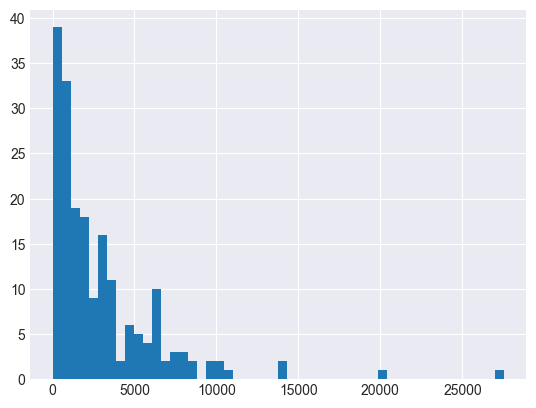

In [85]:
plt.hist(zeros,bins=50)
plt.show()

**_In the Jupyter notebook it was mentioned that the process should be repeated (generating the STA again) until there are no similar RFs_**

## Export data

At this point, after a few iterations, the data is ready to be exported.

In [86]:
print(len(DATA_RFS),len(SPT),len(TOTAL_SPIKES))

191 191 191


In [87]:
TO_SAVE = {"STA": STA,
           "S_DATA_STA": S_DATA,
           "T_DATA_STA": T_DATA,
           "SPT": SPT,
           "TIMESTAMPS": TIMESTAMPS,
           "TOTAL_SPIKES": TOTAL_SPIKES,
           "DATA_RFS": DATA_RFS,
           "RFS": RFS}

for elem in TO_SAVE.keys():
    with open("../" + config["paths"]["data_cache"][elem],"wb") as output: 
        pickle.dump(TO_SAVE[elem], output)

___